In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pyedflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 52.2 MB/s eta 0:00:00


In [3]:
!pip install mne
!pip install numpy
!pip install scipy
!pip install pyhht

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 84.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pyedflib
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import  Dense, Conv3D, Dropout, Flatten, BatchNormalization 
from keras.callbacks import EarlyStopping
from random import shuffle
import math
import numpy as np
import statistics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, LSTM, Dense, Flatten, Input, Embedding, Multiply, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

In [5]:
sampleRate = 256
pathDataSet = '/content/drive/MyDrive/chb-mit-scalp-eeg-database-1.0.0'# path of the dataset
FirstPartPathOutput='/content/drive/MyDrive/spectrograms' #path where the spectogram will be saved
patients = ["23"]
_30_MINUTES_OF_DATA = 256*60*30
_MINUTES_OF_DATA_BETWEEN_PRE_AND_SEIZURE = 3 
_MINUTES_OF_PREICTAL = 30
_SIZE_WINDOW_IN_SECONDS = 30
_SIZE_WINDOW_SPECTOGRAM = _SIZE_WINDOW_IN_SECONDS*256
nSpectogram=0
signalsBlock=None
SecondPartPathOutput=''
legendOfOutput=''
isPreictal=''


    

In [6]:
def loadParametersFromFile(filePath):
    global pathDataSet
    global FirstPartPathOutput
    if(os.path.isfile(filePath)):
        with open(filePath, "r") as f:
                line=f.readline()
                if(line.split(":")[0]=="pathDataSet"):
                    pathDataSet=line.split(":")[1].strip()
                line=f.readline()
                if(line.split(":")[0]=="FirstPartPathOutput"):
                    FirstPartPathOutput=line.split(":")[1].strip()
                
def emd(signal,indexPatient, fileOfData):
    imfs = []
    chbmit_dataset = []
    imf_dataset = []
    file_path=pathDataSet+'/chb'+patients[indexPatient]+'/'+fileOfData
    raw = mne.io.read_raw_edf(file_path, preload=False)
    data = raw.get_data()
    chbmit_dataset.append(data)
    chbmit_dataset = np.array(chbmit_dataset)
    signal = chbmit_dataset[0,1,:]
    while True:
        # Decompose signal into IMF and residue
        imf, residue = pywt.swt(signal, 'db1')[0]
        # Check if IMF is monotonic
        if is_monotonic(imf):
            imfs.append(imf)
            break
        imfs.append(imf)
        signal = residue
    return imfs

def is_monotonic(signal):
    return (np.all(np.diff(signal) >= 0) or np.all(np.diff(signal) <= 0))


def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    i, u = butter(order, [low, high], btype='bandstop')
    y = lfilter(i, u, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = lfilter(b, a, data)
    return y

def loadSummaryPatient(index):
    f = open(pathDataSet+'/chb'+patients[index]+'/chb'+patients[index]+'-summary.txt', 'r')
    return f


def loadDataOfPatient(indexPatient, fileOfData):
    f = pyedflib.EdfReader(pathDataSet+'/chb'+patients[indexPatient]+'/'+fileOfData)  
    n = f.signals_in_file
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    sigbufs=cleanData(sigbufs, indexPatient)
    return sigbufs

def cleanData(Data, indexPatient):
    if(patients[indexPatient] in ["19"]):
        Data=np.delete(Data, 22, axis=0)
        Data=np.delete(Data, 17, axis=0)
        Data=np.delete(Data, 12, axis=0)
        Data=np.delete(Data, 9, axis=0)
        Data=np.delete(Data, 4, axis=0)
    return Data


def getTime(dateInString):
    time=0
    try:
        time = datetime.strptime(dateInString, '%H:%M:%S')
    except ValueError:
        dateInString=" "+dateInString
        if(' 24' in dateInString):
            dateInString = dateInString.replace(' 24', '23')
            time = datetime.strptime(dateInString, '%H:%M:%S')
            time += timedelta(hours=1)
        elif(' 25' in dateInString):
            dateInString = dateInString.replace(' 25', '23')
            time = datetime.strptime(dateInString, '%H:%M:%S')
            time += timedelta(hours=2)
        else:
            dateInString = dateInString.replace(' 26', '23')
            time = datetime.strptime(dateInString, '%H:%M:%S')
            time += timedelta(hours=3)
    return time

def saveSignalsOnDisk(signalsBlock, nSpectogram):
    global SecondPartPathOutput
    global FirstPartPathOutput
    global legendOfOutput
    global isPreictal

    if not os.path.exists(FirstPartPathOutput):
        os.makedirs(FirstPartPathOutput)
    if not os.path.exists(FirstPartPathOutput+SecondPartPathOutput):
        os.makedirs(FirstPartPathOutput+SecondPartPathOutput) 
    np.save(FirstPartPathOutput+SecondPartPathOutput+'/spec_'+isPreictal+'_'+str(nSpectogram-signalsBlock.shape[0])+'_'+str(nSpectogram-1), signalsBlock)
    legendOfOutput=legendOfOutput+str(nSpectogram-signalsBlock.shape[0])+' '+str(nSpectogram-1) +' '+SecondPartPathOutput+'/spec_'+isPreictal+'_'+str(nSpectogram-signalsBlock.shape[0])+'_'+str(nSpectogram-1) +'.npy\n'



def createSpectrogram(data, S=0):
    global nSpectogram
    global signalsBlock
    global inB
    signals=np.zeros((22,59,114))
    
    t=0
    movement=int(S*256)
    if(S==0):
        movement=_SIZE_WINDOW_SPECTOGRAM        
    while data.shape[1]-(t*movement+_SIZE_WINDOW_SPECTOGRAM) > 0:
        
        for i in range(0, 22):
            start = t*movement
            stop = start+_SIZE_WINDOW_SPECTOGRAM
            signals[i,:]=createSpec(data[i,start:stop])
        if(signalsBlock is None):
            signalsBlock=np.array([signals])
        else:
            signalsBlock=np.append(signalsBlock, [signals], axis=0)
        nSpectogram=nSpectogram+1
        if(signalsBlock.shape[0]==50):
            saveSignalsOnDisk(signalsBlock, nSpectogram)
            signalsBlock=None
             
        t = t+1
    return (data.shape[1]-t*_SIZE_WINDOW_SPECTOGRAM)*-1







In [7]:
def createSpec(data):
    fs=256
    lowcut=117
    highcut=123

    y=butter_bandstop_filter(data, lowcut, highcut, fs, order=6)
    lowcut=57
    highcut=63
    y=butter_bandstop_filter(y, lowcut, highcut, fs, order=6)
    
    cutoff=1
    y=butter_highpass_filter(y, cutoff, fs, order=6)
    
    Pxx=signal.spectrogram(y, nfft=256, fs=256, return_onesided=True, noverlap=128)[2]    
    Pxx = np.delete(Pxx, np.s_[117:123+1], axis=0)
    Pxx = np.delete(Pxx, np.s_[57:63+1], axis=0)
    Pxx = np.delete(Pxx, 0, axis=0)
    
    result=(10*np.log10(np.transpose(Pxx))-(10*np.log10(np.transpose(Pxx))).min())/(10*np.log10(np.transpose(Pxx))).ptp()
    return result


In [8]:
class PreIntData:
    start=0
    end=0
    def __init__(self, s, e):
        self.start=s
        self.end=e
       
class FileData:
    start=0
    end=0
    nameFile=""
    def __init__(self, s, e, nF):
        self.start=s
        self.end=e
        self.nameFile=nF



def createArrayIntervalData(fSummary):
    preictalInteval=[]
    interictalInterval=[]
    interictalInterval.append(PreIntData(datetime.min, datetime.max))
    files=[]
    firstTime=True
    oldTime=datetime.min
    startTime=0
    line=fSummary.readline()
    endS=datetime.min
    while(line):
        data=line.split(':')
        if(data[0]=="File Name"):
            nF=data[1].strip()
            s=getTime((fSummary.readline().split(": "))[1].strip())
            if(firstTime):
                interictalInterval[0].start=s
                firstTime=False
                startTime=s
            while s<oldTime:
                s=s+ timedelta(hours=24)
            oldTime=s
            endTimeFile=getTime((fSummary.readline().split(": "))[1].strip())
            while endTimeFile<oldTime:
                endTimeFile=endTimeFile+ timedelta(hours=24)
            oldTime=endTimeFile
            files.append(FileData(s, endTimeFile,nF))
            for j in range(0, int((fSummary.readline()).split(':')[1])):
                secSt=int(fSummary.readline().split(': ')[1].split(' ')[0])
                secEn=int(fSummary.readline().split(': ')[1].split(' ')[0])
                ss=s+timedelta(seconds=secSt)- timedelta(minutes=_MINUTES_OF_DATA_BETWEEN_PRE_AND_SEIZURE+_MINUTES_OF_PREICTAL)
                if((len(preictalInteval)==0 or ss > endS) and ss-startTime>timedelta(minutes=20)):
                    ee=ss+ timedelta(minutes=_MINUTES_OF_PREICTAL) 
                    preictalInteval.append(PreIntData(ss,ee))
                endS=s+timedelta(seconds=secEn)
                ss=s+timedelta(seconds=secSt)- timedelta(hours=4) 
                ee=s+timedelta(seconds=secEn)+ timedelta(hours=4) 
                if(interictalInterval[len(interictalInterval)-1].start<ss and interictalInterval[len(interictalInterval)-1].end>ee):
                    interictalInterval[len(interictalInterval)-1].end=ss
                    interictalInterval.append(PreIntData(ee, datetime.max))
                else:
                    if(interictalInterval[len(interictalInterval)-1].start<ee):
                        interictalInterval[len(interictalInterval)-1].start=ee
        line=fSummary.readline()
    fSummary.close()
    interictalInterval[len(interictalInterval)-1].end=endTimeFile
    return preictalInteval, interictalInterval, files
    


In [9]:
def main():
    global SecondPartPathOutput
    global FirstPartPathOutput
    global legendOfOutput
    global nSpectogram
    global signalsBlock
    global isPreictal
    print("START \n")
    loadParametersFromFile("PARAMETERS_DATA_EDITING.txt")
    print("Parameters loaded")
    
    for indexPatient in range(0, len(patients)):
        print("Working on patient "+patients[indexPatient])
        legendOfOutput=""
        allLegend=""
        nSpectogram=0
        
        SecondPartPathOutput='/paz'+patients[indexPatient]
        f = loadSummaryPatient(indexPatient)
        preictalInfo, interictalInfo, filesInfo=createArrayIntervalData(f)
        if(patients[indexPatient]=="19"):
            preictalInfo.pop(0) 
        print("Summary patient loaded")
        
       
        print("START creation interictal spectrogram")
        totInst=0
        #c=0
        #d=0   
        interictalData = np.array([]).reshape(22,0)       
        indexInterictalSegment=0      
        isPreictal=''
        for fInfo in filesInfo:
            fileS=fInfo.start
            fileE=fInfo.end
            intSegStart=interictalInfo[indexInterictalSegment].start
            intSegEnd=interictalInfo[indexInterictalSegment].end
            while(fileS>intSegEnd and indexInterictalSegment<len(interictalInfo)):
                indexInterictalSegment=indexInterictalSegment+1
                intSegStart=interictalInfo[indexInterictalSegment].start
                intSegEnd=interictalInfo[indexInterictalSegment].end
            start=0
            end=0
            if(not fileE<intSegStart or fileS>intSegEnd):
                if(fileS>=intSegStart):
                    start=0
                else:
                    start=(intSegStart-fileS).seconds
                if(fileE<=intSegEnd):
                    end=None
                else:
                    end=(intSegEnd-fileS).seconds
                tmpData=loadDataOfPatient(indexPatient, fInfo.nameFile)
                if(not end==None):
                    end=end*256
                if(tmpData.shape[0]<22):
                    print(patients[indexPatient] +"  IT HAS LESS NUMBER OF CHANNELS")
                else:
                    interictalData=np.concatenate((interictalData, tmpData[0:22,start*256:end]), axis=1)
                    notUsed= createSpectrogram(interictalData)
                    totInst+=interictalData.shape[1]/256-notUsed/256       
                    interictalData = np.delete(interictalData, np.s_[0:interictalData.shape[1]-notUsed], axis=1)
                    
        S=(_SIZE_WINDOW_IN_SECONDS*(len(preictalInfo)*_MINUTES_OF_PREICTAL*60-_SIZE_WINDOW_IN_SECONDS*len(preictalInfo)))/totInst 
        if(not (signalsBlock is None)):  
            saveSignalsOnDisk(signalsBlock, nSpectogram)
        signalsBlock=None
            
        print("Spectrogram interictal: "+ str(nSpectogram))
        print("Hours interictal: " +str(totInst/60/60))
        legendOfOutput=str(nSpectogram)+"\n"+legendOfOutput
        legendOfOutput="INTERICTAL"+"\n"+legendOfOutput
        legendOfOutput="SEIZURE: " +str(len(preictalInfo))+"\n"+legendOfOutput
        legendOfOutput=patients[indexPatient]+"\n"+legendOfOutput
        allLegend=legendOfOutput
        legendOfOutput=''
        nSpectogram=0
        print("END creation interictal spectrogram")
        
        print("START creation preictal spectrogram")
        isPreictal='P'
        contSeizure=-1
        for pInfo in preictalInfo:
            contSeizure=contSeizure+1
            legendOfOutput=legendOfOutput+"SEIZURE "+str(contSeizure)+"\n"
            preictalData = np.array([]).reshape(22,0)
            j=0
            for j in range(0,len(filesInfo)):
                if(pInfo.start>=filesInfo[j].start and pInfo.start<filesInfo[j].end):
                    break
            start=(pInfo.start-filesInfo[j].start).seconds
            if(start<0):
                start=0 
            end=None
            tmpData=[]
            if(pInfo.end<=filesInfo[j].end):
                end=(pInfo.end-filesInfo[j].start).seconds
                tmpData=loadDataOfPatient(indexPatient, filesInfo[j].nameFile)
                preictalData=np.concatenate((preictalData, tmpData[0:22,start*256:end*256]), axis=1)
            else:
                tmpData=loadDataOfPatient(indexPatient, filesInfo[j].nameFile)
                preictalData=np.concatenate((preictalData, tmpData[0:22,start*256:]), axis=1)
                end=(pInfo.end-filesInfo[j+1].start).seconds
                tmpData=loadDataOfPatient(indexPatient, filesInfo[j+1].nameFile)
                preictalData=np.concatenate((preictalData, tmpData[0:22,0:end*256]), axis=1)
            notUsed= createSpectrogram(preictalData, S=S)
            if(not (signalsBlock is None)): 
                saveSignalsOnDisk(signalsBlock, nSpectogram)
            signalsBlock=None
        
        allLegend=allLegend+"\n"+"PREICTAL"+"\n"+str(nSpectogram)+"\n"+legendOfOutput
        print("Spectrogram preictal: "+ str(nSpectogram))
        print("SEIZURE: " +str(len(preictalInfo)))
        print("END creation preictal spectrogram")
         
        text_file = open(FirstPartPathOutput+SecondPartPathOutput+"/legendAllData.txt", "w")
        text_file.write(allLegend)
        text_file.close()
        print("Legend saved on disk")
        print('\n')
    print("END")
            

if __name__ == '__main__':
    main()

START 

Parameters loaded
Working on patient 23
Summary patient loaded
START creation interictal spectrogram
Spectrogram interictal: 1702
Hours interictal: 14.252777777777776
END creation interictal spectrogram
START creation preictal spectrogram
Spectrogram preictal: 1690
SEIZURE: 5
END creation preictal spectrogram
Legend saved on disk


END


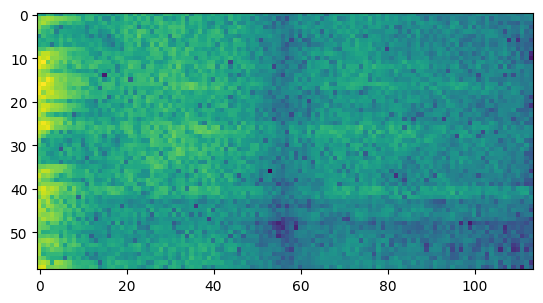

In [ ]:
img=np.load('/content/drive/MyDrive/spectrograms/paz22/spec_P_1039_1088.npy')


plt.imshow(img[0][0])


In [ ]:
plt.imshow(img[0][1])

In [ ]:



PathSpectogramFolder='/content/drive/MyDrive/spectrograms'
OutputPath='/content/results.txt'
OutputPathModels='/content/drive/MyDrive/chbmit-1.0.0.physionet.org'
interictalSpectograms=[]
preictalSpectograms=[]  #This array contains syntetic data, it's created to have a balance dataset and it's used for training
preictalRealSpectograms=[]  #This array containt the real preictal data, it's used for testing
#use patients list selected in the begining
patients = ["23"]
nSeizure=0

def loadParametersFromFile(filePath):
    global PathSpectogramFolder
    global OutputPath
    global OutputPathModels
    if(os.path.isfile(filePath)):
        with open(filePath, "r") as f:
                line=f.readline()
                if(line.split(":")[0]=="PathSpectogramFolder"):
                    PathSpectogramFolder=line.split(":")[1].strip()
                line=f.readline()
                if(line.split(":")[0]=="OutputPath"):
                    OutputPath=line.split(":")[1].strip()
                line=f.readline()
                if(line.split(":")[0]=="OutputPathModels"):
                    OutputPathModels=line.split(":")[1].strip()

def loadSpectogramData(indexPat):
    global interictalSpectograms
    global preictalSpectograms
    global preictalRealSpectograms
    global nSeizure
    nFileForSeizure=0
    
    interictalSpectograms=[]
    preictalSpectograms=[]
    preictalRealSpectograms=[]
    
    f = open(PathSpectogramFolder+'/paz'+patients[indexPat]+'/legendAllData.txt', 'r')
    line=f.readline()
    while(not "SEIZURE" in line):
        line=f.readline()
    nSeizure=int(line.split(":")[1].strip())
    line=f.readline()
    line=f.readline()
    nSpectograms=int(line.strip())
    nFileForSeizure=math.ceil(math.ceil(nSpectograms/50)/nSeizure)
    line=f.readline()
    
    
    cont=-1
    indFilePathRead=0
    while("npy" in line and indFilePathRead<nSeizure*nFileForSeizure):
        if(indFilePathRead%nFileForSeizure==0):
            interictalSpectograms.append([])
            cont=cont+1
            interictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                interictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
    line=f.readline()
    line=f.readline()
    line=f.readline()

   
    cont=-1
    indFilePathRead=0   
     
    while(line.strip()!=""):
        if("SEIZURE" in line):
            line=f.readline()
            if(len(line.split(' '))>=3):
                preictalSpectograms.append([])
                cont=cont+1
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
                indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
        
    line=f.readline()
    line=f.readline()
    line=f.readline()

    
    cont=-1
    while(line):
        if("SEIZURE" in line):
            line=f.readline()
            preictalRealSpectograms.append([])
            cont=cont+1
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
        else:
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
            
        line=f.readline()
    f.close()

# Generator model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv3D(16, (22, 5, 5), strides=(1, 2, 2), padding='valid',activation='relu',data_format= "channels_first", input_shape=input_shape))
    model.add(Conv3D(32, (1, 3, 3), strides=(1, 1,1), padding='valid',data_format= "channels_first",  activation='relu'))   
    model.add(Conv3D(64, (1,3, 3), strides=(1, 1,1), padding='valid',data_format= "channels_first",  activation='relu'))
    return model

# Discriminator model
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Conv3D(16, (22, 5, 5), strides=(1, 2, 2), padding='valid',activation='relu',data_format= "channels_first", input_shape=input_shape))
    model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2),data_format= "channels_first",  padding='same'))
    model.add(BatchNormalization())
    model.add(Conv3D(32, (1, 3, 3), strides=(1, 1,1), padding='valid',data_format= "channels_first",  activation='relu'))
    model.add(keras.layers.MaxPooling3D(pool_size=(1,2, 2),data_format= "channels_first", ))
    model.add(BatchNormalization())
    
    model.add(Conv3D(64, (1,3, 3), strides=(1, 1,1), padding='valid',data_format= "channels_first",  activation='relu'))
    model.add(keras.layers.MaxPooling3D(pool_size=(1,2, 2),data_format= "channels_first", ))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    

# LSTM model
def build_lstm(sequence_length, latent_dim):
    model = Sequential()
    model.add(LSTM(64, input_shape=(sequence_length, latent_dim)))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build():
    input_shape = (1,2,59,114)
    latent_dim = 100
    sequence_length = 50
    generator = build_generator(latent_dim)
    discriminator = build_discriminator(input_shape)
    lstm = build_lstm(sequence_length, latent_dim)
  
def createModel():
    input_shape=(1, 22, 59, 114)
    model = Sequential()
    #C1
    model.add(Conv3D(16, (22, 5, 5), strides=(1, 2, 2), padding='valid',activation='relu',data_format= "channels_first", input_shape=input_shape))
    model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2),data_format= "channels_first",  padding='same'))
    model.add(BatchNormalization())
    
    #C2
    model.add(Conv3D(32, (1, 3, 3), strides=(1, 1,1), padding='valid',data_format= "channels_first",  activation='relu'))
    model.add(keras.layers.MaxPooling3D(pool_size=(1,2, 2),data_format= "channels_first", ))
    model.add(BatchNormalization())
    
    #C3
    model.add(Conv3D(64, (1,3, 3), strides=(1, 1,1), padding='valid',data_format= "channels_first",  activation='relu'))
    model.add(keras.layers.MaxPooling3D(pool_size=(1,2, 2),data_format= "channels_first", ))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    opt_adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    
    return model

def getFilesPathWithoutSeizure(indexSeizure, indexPat):
    filesPath=[]
    for i in range(0, nSeizure):
        if(i!=indexSeizure):
            filesPath.extend(interictalSpectograms[i])
            filesPath.extend(preictalSpectograms[i])
    shuffle(filesPath)
    return filesPath


def generate_arrays_for_training(indexPat, paths, start=0, end=100):
    while True:
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            if('P' in f):
                y = np.repeat([[0,1]],x.shape[0], axis=0)
            else:
                y =np.repeat([[1,0]],x.shape[0], axis=0)
            yield(x,y)
            
def generate_arrays_for_predict(indexPat, paths, start=0, end=100):
    while True:
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            yield(x)

class EarlyStoppingByLossVal(keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0, lower=True):
        super(keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.lower=lower

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if self.lower:
            if current < self.value:
                if self.verbose > 0:
                    print("Epoch %05d: early stopping THR" % epoch)
                self.model.stop_training = True
     #critical secton   

def main():
    print("START")
    if not os.path.exists(OutputPathModels):
        os.makedirs(OutputPathModels)
    loadParametersFromFile("PARAMETERS_CNN.txt")
    
    callback=EarlyStoppingByLossVal(monitor='val_acc', value=0.975, verbose=1, lower=False)
    print("Parameters loaded")
    
    for indexPat in range(0, len(patients)):
        print('Patient '+patients[indexPat])
        if not os.path.exists(OutputPathModels+"ModelPat"+patients[indexPat]+"/"):
            os.makedirs(OutputPathModels+"ModelPat"+patients[indexPat]+"/")
        loadSpectogramData(indexPat) 
        print('Spectograms data loaded')
        
        result='Patient '+patients[indexPat]+'\n'     
        result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
        for i in range(0, nSeizure):
            print('SEIZURE OUT: '+str(i+1))
            
            print('Training start')  
            model = createModel()
            filesPath=getFilesPathWithoutSeizure(i, indexPat)
            
            model.fit_generator(generate_arrays_for_training(indexPat, filesPath, end=75), #end=75),#It take the first 75%
                                validation_data=generate_arrays_for_training(indexPat, filesPath, start=75),#start=75), #It take the last 25%
                                #steps_per_epoch=10000, epochs=10)
                                steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))),#*25), 
                                validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))),#*75),
                                verbose=2,
                                epochs=280, max_queue_size=2, shuffle=True, callbacks=[callback])# 100 epochs è meglio #aggiungere criterio di stop in base accuratezza
            print('Training end')
            
            print('Testing start')
            filesPath=interictalSpectograms[i]
            interPrediction=model.predict_generator(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
            filesPath=preictalRealSpectograms[i]
            preictPrediction=model.predict_generator(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
            print('Testing end')
            

            # Creates a HDF5 file 
            model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
            print("Model saved")
            
            if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
                os.makedirs(OutputPathModels+"OutputTest"+"/")
            np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
            np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")
            
            secondsInterictalInTest=len(interictalSpectograms[i])*50*30#50 spectograms for file, 30 seconds for each spectogram
            acc=0#accumulator
            fp=0
            tp=0
            fn=0
            lastTenResult=list()
            
            for el in interPrediction:
                if(el[1]>0.5):
                    acc=acc+1
                    lastTenResult.append(1)
                else:
                    lastTenResult.append(0)
                if(len(lastTenResult)>10):
                    acc=acc-lastTenResult.pop(0)
                if(acc>=8):
                  fp=fp+1
                  lastTenResult=list()
                  acc=0
            
            lastTenResult=list()
            for el in preictPrediction:
                if(el[1]>0.5):
                    acc=acc+1
                    lastTenResult.append(1)
                else:
                    lastTenResult.append(0)
                if(len(lastTenResult)>10):
                    acc=acc-lastTenResult.pop(0)
                if(acc>=8):
                  tp=tp+1 
                else:
                    if(len(lastTenResult)==10):
                       fn=fn+1 
                       
            sensitivity=tp/(tp+fn)
            FPR=fp/(secondsInterictalInTest/(60*60))
            
            result=result+str(i+1)+','+str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','
            result=result+str(sensitivity)+','+str(FPR)+'\n'
            print('True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR')
            print(str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','+str(sensitivity)+','+str(FPR))
        with open(OutputPath, "a+") as myfile:
            myfile.write(result)
    

if __name__ == '__main__':
    main()
    


START
Parameters loaded
Patient 23
Spectograms data loaded
SEIZURE OUT: 1
Training start


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-9-b671816773dd>:213: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generate_arrays_for_training(indexPat, filesPath, end=75), #end=75),#It take the first 75%


Epoch 1/280
42/42 - 145s - loss: 0.8689 - accuracy: 0.4940 - val_loss: 0.6858 - val_accuracy: 0.5671 - 145s/epoch - 3s/step
Epoch 2/280
42/42 - 12s - loss: 0.8579 - accuracy: 0.5135 - val_loss: 0.6858 - val_accuracy: 0.5671 - 12s/epoch - 297ms/step
Epoch 3/280
42/42 - 15s - loss: 0.8604 - accuracy: 0.5010 - val_loss: 0.6884 - val_accuracy: 0.5671 - 15s/epoch - 368ms/step
Epoch 4/280
42/42 - 7s - loss: 0.8573 - accuracy: 0.5075 - val_loss: 0.6906 - val_accuracy: 0.5671 - 7s/epoch - 160ms/step
Epoch 5/280
42/42 - 8s - loss: 0.8539 - accuracy: 0.5130 - val_loss: 0.6900 - val_accuracy: 0.5671 - 8s/epoch - 200ms/step
Epoch 6/280
42/42 - 7s - loss: 0.8437 - accuracy: 0.5090 - val_loss: 0.6878 - val_accuracy: 0.5671 - 7s/epoch - 172ms/step
Epoch 7/280
42/42 - 8s - loss: 0.8706 - accuracy: 0.4920 - val_loss: 0.6837 - val_accuracy: 0.5671 - 8s/epoch - 180ms/step
Epoch 8/280
42/42 - 7s - loss: 0.8475 - accuracy: 0.5090 - val_loss: 0.6805 - val_accuracy: 0.5671 - 7s/epoch - 168ms/step
Epoch 9/280

<ipython-input-9-b671816773dd>:224: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  interPrediction=model.predict_generator(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
<ipython-input-9-b671816773dd>:226: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preictPrediction=model.predict_generator(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))


Testing end
Model saved
True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR
49,2,2,10500,0.9607843137254902,0.6857142857142857
SEIZURE OUT: 2
Training start
Epoch 1/280
42/42 - 25s - loss: 0.9192 - accuracy: 0.5156 - val_loss: 0.9176 - val_accuracy: 0.3907 - 25s/epoch - 606ms/step
Epoch 2/280
42/42 - 7s - loss: 0.8297 - accuracy: 0.5257 - val_loss: 0.8384 - val_accuracy: 0.3907 - 7s/epoch - 170ms/step
Epoch 3/280
42/42 - 8s - loss: 0.8287 - accuracy: 0.5195 - val_loss: 0.7877 - val_accuracy: 0.3907 - 8s/epoch - 193ms/step
Epoch 4/280
42/42 - 7s - loss: 0.8311 - accuracy: 0.5204 - val_loss: 0.7546 - val_accuracy: 0.3907 - 7s/epoch - 174ms/step
Epoch 5/280
42/42 - 7s - loss: 0.8147 - accuracy: 0.5142 - val_loss: 0.7274 - val_accuracy: 0.3907 - 7s/epoch - 173ms/step
Epoch 6/280
42/42 - 7s - loss: 0.8158 - accuracy: 0.5142 - val_loss: 0.6993 - val_accuracy: 0.3907 - 7s/epoch - 172ms/step
Epoch 7/280
42/42 - 8s - loss: 0.8325 - accuracy: 0.5051 - val_los

In [ ]:

OutputPathModels=['/content/chbmit-1.0.0.physionet.org',
                  '/content/chbmit-1.0.0.physionet.org'] 
def dataProc():
    pat=["01"]
    nSeizure=[2]
    secondsInterictalInTest=[7500,31500, 10500, 46500, 21000,10500]
    threshold=[0.6,0.8, 0.4, 0.001, 0.3,0.3]
    for j in range(0,len(pat)):
        sensResults=[]
        FPRResults=[]
        for k in range(0,2):
            for i in range(0, nSeizure[j]):            
                interPrediction=np.loadtxt(OutputPathModels[k]+"OutputTest"+"/"+"Int_"+pat[j]+"_"+str(i+1)+".csv",delimiter=',')
                preictPrediction=np.loadtxt(OutputPathModels[k]+"OutputTest"+"/"+"Pre_"+pat[j]+"_"+str(i+1)+".csv",delimiter=',')
                
                acc=0#accumulator
                fp=0
                tp=0
                fn=0
                lastTenResult=list()
                
                for el in interPrediction:
                    if(el[1]>threshold[j]):
                        acc=acc+1
                        lastTenResult.append(1)
                    else:
                        lastTenResult.append(0)
                    if(len(lastTenResult)>10):
                        acc=acc-lastTenResult.pop(0)
                    if(acc>=8):
                      fp=fp+1
                      lastTenResult=list()
                      acc=0
                
                lastTenResult=list()
                for el in preictPrediction:
                    if(el[1]>threshold[j]):
                        acc=acc+1
                        lastTenResult.append(1)
                    else:
                        lastTenResult.append(0)
                    if(len(lastTenResult)>10):
                        acc=acc-lastTenResult.pop(0)
                    if(acc>=8):
                      tp=tp+1 
                    else:
                        if(len(lastTenResult)==10):
                           fn=fn+1 
                           
                sensitivity=tp/(tp+fn)*100
                FPR=fp/(secondsInterictalInTest[j]/(60*60))
                sensResults.append(sensitivity)
                FPRResults.append(FPR)
                
        sdSENS=statistics.stdev(sensResults)
        avSENS=statistics.mean(sensResults)
        
        sdFPR=statistics.stdev(FPRResults)
        avFPR=statistics.mean(FPRResults)
        print(pat[j]+"   AVG_Sens= "+str(avSENS)+" +- "+str(sdSENS)+"   AVG_FPR= "+str(avFPR)+" +- "+str(sdFPR))



In [ ]:
dataProc()